# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [191]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(style='white', font_scale=1.0, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter

import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from 
https://gssdataexplorer.norc.org/projects/48515

In [192]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [193]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [194]:
replace_invalid(gss)

In [195]:
def numnull(series):
    return sum(series.isnull())

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [196]:
numnull(gss.gunlaw)

21994

In [197]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [198]:
numnull(gss.owngun)

24826

In [199]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [200]:
numnull(gss.gun)

43138

In [201]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [202]:
numnull(gss.natcrime)

28064

In [203]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [204]:
varname = 'income'
numnull(gss[varname])

7961

In [205]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [206]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [207]:
varname = 'realinc'
numnull(gss[varname])

6325

In [208]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [209]:
varname = 'educ'
numnull(gss[varname])

174

In [210]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [211]:
varname = 'polviews'
numnull(gss[varname])

9385

In [212]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [213]:
numnull(gss.age)

221

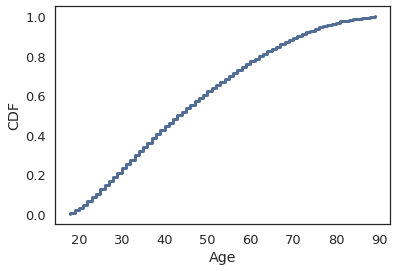

In [214]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [215]:
numnull(gss.cohort)

221

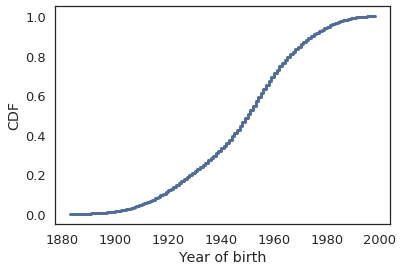

In [216]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [217]:
numnull(gss.sex)

0

In [218]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [219]:
numnull(gss.race)

0

In [220]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [221]:
numnull(gss.hispanic)

38149

In [222]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [223]:
numnull(gss.srcbelt)

0

In [224]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

### Make age and cohort groups

In [225]:
def make_groups(gss):
    gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5    
    gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
    gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
    gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
    gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
    gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
    gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5

In [226]:
make_groups(gss)

Group people into 5- and 10-year bins by birth year.

In [227]:
# count cases where we have the dependent var
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [228]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

In [229]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     393
2000.0     132
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [230]:
utils.values(gss, 'year')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [231]:
utils.values(gss, 'year4')

1971    3117
1975    6003
1979    3000
1983    6466
1987    6307
1991    4495
1995    5896
1999    5649
2003    5577
2007    6533
2011    4018
2015    5405
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [232]:
utils.values(gss, 'age5')

17.5    1054
22.5    5283
27.5    6663
32.5    6784
37.5    6475
42.5    5924
47.5    5375
52.5    5007
57.5    4530
62.5    4047
67.5    3612
72.5    2955
77.5    2207
82.5    1381
87.5     948
92.5     221
Name: age5, dtype: int64

In [233]:
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     840
85.5     573
88.5     591
91.5     221
Name: age3, dtype: int64

### Make booleans

In [234]:
def copy_nan(df, varname, newvar):
    """Put a NaN into newvar in any place where varname is Nan.
    
    df: DataFrame
    varname: string old var name
    newvar: string new var name
    """
    df.loc[df[varname].isnull(), newvar] = np.nan

In [235]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [236]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    quantile25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= quantile25 
    copy_nan(df, 'realinc', 'lowrealinc')

    quantile75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= quantile75 
    copy_nan(df, 'realinc', 'highrealinc')

In [237]:
make_booleans(gss)

### Resample

Divide the sample up by year; resample within each year, using sampling weights; then concatenate the annual samples.

In [238]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(62466, 56)

In [239]:
utils.values(sample, 'twenties')

0.0    56460
1.0     6006
Name: twenties, dtype: int64

In [240]:
utils.values(sample, 'thirties')

0.0    55443
1.0     7023
Name: thirties, dtype: int64

In [241]:
utils.values(sample, 'forties')

0.0    52257
1.0    10209
Name: forties, dtype: int64

In [242]:
utils.values(sample, 'fifties')

0.0    49483
1.0    12983
Name: fifties, dtype: int64

In [243]:
utils.values(sample, 'sixties')

0.0    52577
1.0     9889
Name: sixties, dtype: int64

In [244]:
utils.values(sample, 'seventies')

0.0    56343
1.0     6123
Name: seventies, dtype: int64

In [245]:
utils.values(sample, 'eighties')

0.0    59202
1.0     3264
Name: eighties, dtype: int64

In [246]:
utils.values(sample, 'nineties')

0.0    61585
1.0      881
Name: nineties, dtype: int64

In [247]:
utils.values(sample, 'favor')

0.0     9573
1.0    31021
Name: favor, dtype: int64

In [248]:
utils.values(sample, 'gunhome')

0.0    21500
1.0    16146
Name: gunhome, dtype: int64

In [249]:
utils.values(sample, 'threatened')

0.0    15631
1.0     3729
Name: threatened, dtype: int64

In [250]:
utils.values(sample, 'spendcrime')

0.0    11274
1.0    23195
Name: spendcrime, dtype: int64

In [251]:
utils.values(sample, 'topincome')

0.0    24272
1.0    29717
Name: topincome, dtype: int64

In [252]:
utils.values(sample, 'lowincome')

0.0    45415
1.0     8574
Name: lowincome, dtype: int64

In [253]:
utils.values(sample, 'lowrealinc')

0.0    44106
1.0    11539
Name: lowrealinc, dtype: int64

In [254]:
utils.values(sample, 'highrealinc')

0.0    39136
1.0    16509
Name: highrealinc, dtype: int64

In [255]:
utils.values(sample, 'liberal')

0.0    39029
1.0    14108
Name: liberal, dtype: int64

In [256]:
utils.values(sample, 'moderate')

0.0    32567
1.0    20570
Name: moderate, dtype: int64

In [257]:
utils.values(sample, 'conservative')

0.0    43374
1.0     9763
Name: conservative, dtype: int64

In [258]:
utils.values(sample, 'female')

0.0    28458
1.0    34008
Name: female, dtype: int64

In [259]:
utils.values(sample, 'ishisp')

0.0    22468
1.0     1847
Name: ishisp, dtype: int64

In [260]:
utils.values(sample, 'black')

0.0    54099
1.0     8367
Name: black, dtype: int64

In [261]:
utils.values(sample, 'otherrace')

0.0    58796
1.0     3670
Name: otherrace, dtype: int64

In [262]:
utils.values(sample, 'urban')

0.0    25369
1.0    37097
Name: urban, dtype: int64

In [263]:
utils.values(sample, 'suburban')

0.0    45242
1.0    17224
Name: suburban, dtype: int64

In [264]:
utils.values(sample, 'rural')

0.0    54321
1.0     8145
Name: rural, dtype: int64

In [265]:
utils.values(sample, 'college')

0.0    33424
1.0    28904
Name: college, dtype: int64

### Look at trends

In [266]:
def plot_series(grouped, varname, **options):
    """Plot a series of percentages from each group.
    
    grouped: groupby object
    varname: string variable name
    options: passed to Plot
    """
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options, label=varname)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

Here's what generational replacement looks like.

In [267]:
grouped_year4 = sample.groupby('year4')

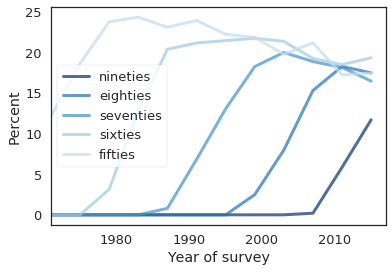

In [268]:
plot_series(grouped_year4, 'nineties')
plot_series(grouped_year4, 'eighties')
plot_series(grouped_year4, 'seventies')
plot_series(grouped_year4, 'sixties')
plot_series(grouped_year4, 'fifties')

Changes in proportions of various groups.

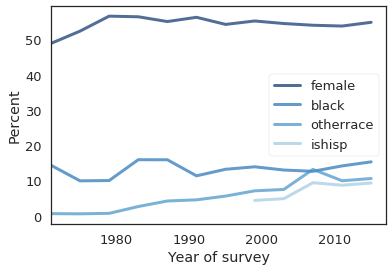

In [269]:
plot_series(grouped_year4, 'female')
plot_series(grouped_year4, 'black')
plot_series(grouped_year4, 'otherrace')
plot_series(grouped_year4, 'ishisp')

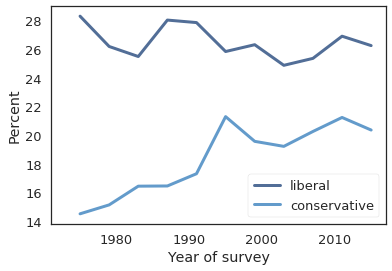

In [270]:
plot_series(grouped_year4, 'liberal')
plot_series(grouped_year4, 'conservative')

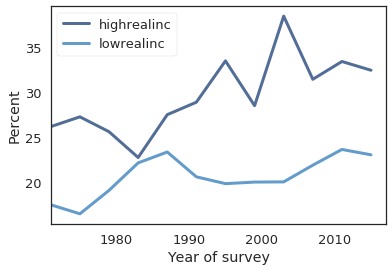

In [271]:
plot_series(grouped_year4, 'highrealinc')
plot_series(grouped_year4, 'lowrealinc')

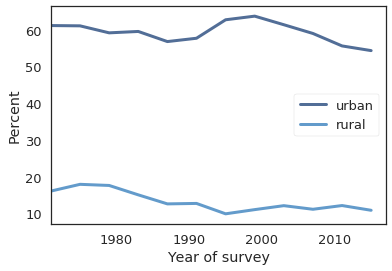

In [272]:
plot_series(grouped_year4, 'urban')
plot_series(grouped_year4, 'rural')

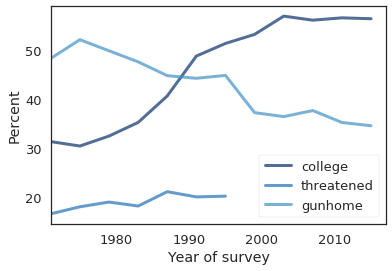

In [273]:
plot_series(grouped_year4, 'college')
plot_series(grouped_year4, 'threatened')
plot_series(grouped_year4, 'gunhome')

### Fill missing values

In [274]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    #print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [275]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    #print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [276]:
def fill_all_missing(df):
    varnames = ['year', 'cohort', 'owngun', 'gun', 'natcrime',
                'income', 'realinc', 'educ', 'polviews',
                'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
        
    # filling age is special because we have to fill cohort
    # to be consistent
    fill_age(df)

In [277]:
fill_all_missing(sample)

After filling, we have to make booleans again.

In [278]:
make_booleans(sample)

### Center cohort, age, and year.

In [279]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [280]:
center_factors(sample)

In [281]:
for varname in ['c', 'a', 'y']:
    print(varname, sample[varname].mean())

c -16.77912784554798
a -2.1472160855505393
y 4.0723593634937405


In [284]:
def run_resampling(iters=101):
    """Run the resampling process and save the results.
    
    iters: number of times to run
    """
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    make_groups(gss)
    
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        
        key = 'iter%d' % i
        #print('Writing', key)
        sample.to_hdf('iterations.h5', key)

In [285]:
%time run_resampling()

Writing iter0
Writing iter1
Writing iter2
Writing iter3
Writing iter4
Writing iter5
Writing iter6
Writing iter7
Writing iter8
Writing iter9
Writing iter10
Writing iter11
Writing iter12
Writing iter13
Writing iter14
Writing iter15
Writing iter16
Writing iter17
Writing iter18
Writing iter19
Writing iter20
Writing iter21
Writing iter22
Writing iter23
Writing iter24
Writing iter25
Writing iter26
Writing iter27
Writing iter28
Writing iter29
Writing iter30
Writing iter31
Writing iter32
Writing iter33
Writing iter34
Writing iter35
Writing iter36
Writing iter37
Writing iter38
Writing iter39
Writing iter40
Writing iter41
Writing iter42
Writing iter43
Writing iter44
Writing iter45
Writing iter46
Writing iter47
Writing iter48
Writing iter49
Writing iter50
Writing iter51
Writing iter52
Writing iter53
Writing iter54
Writing iter55
Writing iter56
Writing iter57
Writing iter58
Writing iter59
Writing iter60
Writing iter61
Writing iter62
Writing iter63
Writing iter64
Writing iter65
Writing iter66
Writi

In [294]:
def read_samples(iters=101):
    """Read samples.
    
    iters: number of times to run
    """
    for i in range(iters):
        key = 'iter%d' % i
        sample = pd.read_hdf('iterations.h5', key)
        yield sample

In [295]:
def run(iters=101):
    for sample in read_samples(iters):
        pass

In [298]:
%time run()

CPU times: user 1.58 s, sys: 1.78 s, total: 3.35 s
Wall time: 21.8 s


### Run logistic models

In [299]:
gss = utils.ReadGss('gss_gun')
replace_invalid(gss)
make_groups(gss)

sample = utils.ResampleByYear(gss).copy()
fill_all_missing(sample)
make_booleans(sample)
center_factors(sample)

subset = sample.dropna(subset=['gunlaw']);

Drop records if we don't have the dependent variable.

In [300]:
subset = sample.dropna(subset=['gunlaw'])
subset.shape

(40477, 65)

How many records did we lose?

In [301]:
sample.shape[0] - subset.shape[0]

21989

In [302]:
subset.head()

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,highrealinc,ones,c,a,y,c2,a2,y2,y3,ac
0,1972,0.0,1935.0,0,0.8893,11.0,3,43994.0,1,0,...,1.0,1.0,-31.0,-10.0,-18,961.0,100.0,324,-5832,310.0
1,1972,0.0,1943.0,0,1.3339,6.0,3,13537.0,2,0,...,0.0,1.0,-23.0,-18.0,-18,529.0,324.0,324,-5832,414.0
2,1972,0.0,1924.0,0,0.8893,11.0,4,60915.0,1,0,...,1.0,1.0,-42.0,1.0,-18,1764.0,1.0,324,-5832,-42.0
3,1972,0.0,1921.0,0,1.7786,10.0,3,30458.0,2,0,...,0.0,1.0,-45.0,4.0,-18,2025.0,16.0,324,-5832,-180.0
4,1972,0.0,1934.0,0,0.8893,8.0,2,8122.0,2,0,...,0.0,1.0,-32.0,-9.0,-18,1024.0,81.0,324,-5832,288.0


In [303]:
sample.columns

Index(['year', 'conrinc', 'cohort', 'ballot', 'wtssall', 'income', 'finrela',
       'realinc', 'sex', 'homosex', 'hispanic', 'rowngun', 'owngun', 'id_',
       'age', 'race', 'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun',
       'gunage', 'gunnum', 'educ', 'cohort5', 'cohort10', 'year4', 'age5',
       'age3', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties', 'favor', 'gunhome', 'threatened',
       'spendcrime', 'topincome', 'lowincome', 'liberal', 'moderate',
       'conservative', 'female', 'ishisp', 'black', 'otherrace', 'urban',
       'suburban', 'rural', 'college', 'lowrealinc', 'highrealinc', 'ones',
       'c', 'a', 'y', 'c2', 'a2', 'y2', 'y3', 'ac'],
      dtype='object')

In [304]:
varnames = ['nineties', 'eighties', 'seventies', 'fifties', 'forties', 'thirties', 'twenties',
            'female', 'black', 'otherrace', 'ishisp', 'conservative', 'liberal', 'lowrealinc', 'highrealinc',
            'college', 'urban', 'rural', 'threatened', 'gunhome']

all_varnames = varnames + ['y', 'y2', 'y3', 'favor']

['nineties',
 'eighties',
 'seventies',
 'fifties',
 'forties',
 'thirties',
 'twenties',
 'female',
 'black',
 'otherrace',
 'ishisp',
 'conservative',
 'liberal',
 'lowrealinc',
 'highrealinc',
 'college',
 'urban',
 'rural',
 'threatened',
 'gunhome',
 'y',
 'y2',
 'y3',
 'favor']

In [305]:
for varname in varnames:
    print(varname, sum(sample[varname].isnull()))

nineties 0
eighties 0
seventies 0
fifties 0
forties 0
thirties 0
twenties 0
female 0
black 0
otherrace 0
ishisp 0
conservative 0
liberal 0
lowrealinc 0
highrealinc 0
college 0
urban 0
rural 0
threatened 0
gunhome 0


Select just the columns we need

In [306]:
data = subset[all_varnames]
data.shape

(40477, 24)

In [307]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=data).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.504498
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40477
Model:                          Logit   Df Residuals:                    40453
Method:                           MLE   Df Model:                           23
Date:                Fri, 12 Oct 2018   Pseudo R-squ.:                 0.08165
Time:                        11:26:36   Log-Likelihood:                -20421.
converged:                       True   LL-Null:                       -22236.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6023      0.046     34.586      0.000       1.511       1.693
y                0.0298      0.002     12.410      0.000       0.025       0.034
y2           -9.941e-05      0.000     -0.941      0.347      -0.000       0.000
y3           -7.264e-05   6.87e-06    -10.577      0.000   -8.61e-05   -5.92e-05
nineties        -0.6117      0.106     -5.753      0.000      -0.820      -0.403
eighties        -0.2941      0.066     -4.427      0.000      -0.424      -0.164
seventies       -0.1121      0.052     -2.141      0.032      -0.215      -0.009
fifties         -0.0430      0.037     -1.168      0.243      -0.115       0.029
forties          0.0237      0.039      0.606      0.544      -0.053       0.100
thirties        -0.0831      0.043     -1.955      0.051      -0.166       0.000
twenties        -0.0138      0.045     -0.306      0.759      -0.102       0.075
female           0.7147      0.025     28.719      0.000       0.666       0.764
black            0.1801      0.039      4.672      0.000       0.105       0.256
otherrace        0.4114      0.066      6.227      0.000       0.282       0.541
ishisp          -0.0305      0.047     -0.654      0.513      -0.122       0.061
conservative    -0.3987      0.031    -12.801      0.000      -0.460      -0.338
liberal          0.2624      0.031      8.545      0.000       0.202       0.323
lowrealinc      -0.1778      0.031     -5.740      0.000      -0.239      -0.117
highrealinc      0.0342      0.031      1.106      0.269      -0.026       0.095
college          0.0890      0.027      3.326      0.001       0.037       0.141
urban           -0.2756      0.031     -9.012      0.000      -0.336      -0.216
rural           -0.5448      0.041    -13.239      0.000      -0.625      -0.464
threatened      -0.0735      0.030     -2.411      0.016      -0.133      -0.014
gunhome         -0.8663      0.026    -33.529      0.000      -0.917      -0.816
================================================================================
"""

Make a row for someone in 2016 with all booleans false.

In [308]:
def make_base():
    y = 2016 - 1990
    y2 = y**2
    y3 = y**3

    d = dict(y=y, y2=y2, y3=y3)
    for varname in varnames:
        d[varname] = 0

    return pd.Series(d)

base = make_base()
base

y                  26
y2                676
y3              17576
nineties            0
eighties            0
seventies           0
fifties             0
forties             0
thirties            0
twenties            0
female              0
black               0
otherrace           0
ishisp              0
conservative        0
liberal             0
lowrealinc          0
highrealinc         0
college             0
urban               0
rural               0
threatened          0
gunhome             0
dtype: int64

Make a DataFrame that contains one row for each case we want to consider.

In [309]:
def make_df_pred():
    def add_yminus(df, varname, offset):
        """Add a column with y minus an offset.
        
        df: DataFrame
        varname: string new var name
        offset: how much to shift y
        """
        df.loc[varname] = base
        df.loc[varname, 'y'] += offset
        df.loc[varname, 'y2'] = df.loc[varname, 'y']**2
        df.loc[varname, 'y3'] = df.loc[varname, 'y']**3
    
    base = make_base()
    df_pred = pd.DataFrame(columns=base.index, dtype=float)    
    df_pred.loc['base'] = base

    for varname in varnames:
        df_pred.loc[varname] = base
        df_pred.loc[varname, varname] = 1
    
    add_yminus(df_pred, 'yminus10', -10)
    add_yminus(df_pred, 'yminus20', -20)
    add_yminus(df_pred, 'yminus30', -30)
    add_yminus(df_pred, 'yminus40', -40)
    
    df_pred.loc['lowest combo'] = base
    low_vars = ['gunhome', 'nineties', 'rural', 
                'conservative', 'lowrealinc', 'threatened']
    df_pred.loc['lowest combo', low_vars] = 1
    
    df_pred.loc['highest combo'] = base
    high_vars = ['female', 'otherrace', 'liberal', 
                'college', 'highrealinc']
    df_pred.loc['highest combo', high_vars] = 1
    
    return df_pred
    
df_pred = make_df_pred()

,y,y2,y3,nineties,eighties,seventies,fifties,forties,thirties,twenties,...,ishisp,conservative,liberal,lowrealinc,highrealinc,college,urban,rural,threatened,gunhome
base,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nineties,26.0,676.0,17576.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eighties,26.0,676.0,17576.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seventies,26.0,676.0,17576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fifties,26.0,676.0,17576.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thirties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
twenties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
female,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
black,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
pred = model.predict(df_pred) * 100

base             73.742890
nineties         60.370035
eighties         67.668126
seventies        71.516273
fifties          72.902587
forties          74.199392
thirties         72.101742
twenties         73.474461
female           85.162336
black            77.078784
otherrace        80.908613
ishisp           73.148260
conservative     65.339299
liberal          78.499577
lowrealinc       70.158141
highrealinc      74.399557
college          75.428647
urban            68.071747
rural            61.960160
threatened       72.294790
gunhome          54.149863
yminus10         85.268293
yminus20         85.342286
yminus30         81.550890
yminus40         79.660019
lowest combo     16.244627
highest combo    92.719297
dtype: float64

In [311]:
pred - pred['base']

base              0.000000
nineties        -13.372855
eighties         -6.074764
seventies        -2.226617
fifties          -0.840303
forties           0.456502
thirties         -1.641148
twenties         -0.268429
female           11.419446
black             3.335894
otherrace         7.165723
ishisp           -0.594630
conservative     -8.403591
liberal           4.756688
lowrealinc       -3.584749
highrealinc       0.656667
college           1.685757
urban            -5.671143
rural           -11.782730
threatened       -1.448100
gunhome         -19.593027
yminus10         11.525403
yminus20         11.599396
yminus30          7.808000
yminus40          5.917129
lowest combo    -57.498263
highest combo    18.976407
dtype: float64

In [312]:
def make_result(pred):
    """Make a DataFrame with one row per case.
    
    pred: series of predictions
    """
    result = pd.DataFrame()
    result['pred'] = pred
    result['offset'] = pred - pred['base']
    return result

result = make_result(pred)

,pred,offset
base,73.742890,0.000000
nineties,60.370035,-13.372855
eighties,67.668126,-6.074764
seventies,71.516273,-2.226617
fifties,72.902587,-0.840303
forties,74.199392,0.456502
thirties,72.101742,-1.641148
twenties,73.474461,-0.268429
female,85.162336,11.419446
black,77.078784,3.335894


### Iterate

To estimate uncertainty due to random sampling and missing values, we have to iterate the procedure we just ran.

In [314]:
def run(iters=101):
    """Run the model several times and return a collection of results.
    
    iters: number of times to run
    
    returns: list of DataFrames
    """
    results = []
    for sample in read_samples(iters):
        subset = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=subset).fit()

        df_pred = make_df_pred()
        pred = model.predict(df_pred) * 100
        result = make_result(pred)
        
        results.append(result)
    return results

In [315]:
results = run()

Optimization terminated successfully.
         Current function value: 0.502128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507539
  

Optimization terminated successfully.
         Current function value: 0.501293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501220
  

[                    pred     offset
 base           72.826423   0.000000
 nineties       59.309082 -13.517341
 eighties       66.339964  -6.486459
 seventies      72.368277  -0.458145
 fifties        73.006326   0.179903
 forties        73.927511   1.101088
 thirties       71.482495  -1.343928
 twenties       73.898910   1.072487
 female         84.406526  11.580103
 black          76.772281   3.945858
 otherrace      80.250396   7.423973
 ishisp         73.050624   0.224201
 conservative   65.274399  -7.552024
 liberal        77.650218   4.823795
 lowrealinc     71.344156  -1.482266
 highrealinc    75.551328   2.724905
 college        74.523386   1.696963
 urban          67.180745  -5.645678
 rural          60.293280 -12.533143
 threatened     69.666090  -3.160333
 gunhome        52.484818 -20.341605
 yminus10       84.083057  11.256634
 yminus20       84.163748  11.337325
 yminus30       80.610414   7.783991
 yminus40       79.390749   6.564327
 lowest combo   15.969378 -56.857045
 

Process the results.

In [320]:
preds = [result.pred for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 5, 95])

estimates = pd.DataFrame(index=result.index)
estimates['low5'] = low
estimates['median'] = median
estimates['high95'] = high
estimates.round(1)

,low5,median,high95
base,71.8,73.5,75.2
nineties,60.0,64.2,68.0
eighties,65.5,67.5,70.0
seventies,68.0,70.1,72.1
fifties,71.1,72.8,75.0
forties,71.1,73.6,75.5
thirties,70.3,72.2,73.9
twenties,70.7,73.4,75.2
female,83.6,84.7,85.7
black,76.2,77.9,79.5


In [321]:
# generate an HTML table

lines = estimates.round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low5</th>
      <th>median</th>
      <th>high95</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>base</th>
      <td>71.8</td>
      <td>73.5</td>
      <td>75.2</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>60.0</td>
      <td>64.2</td>
      <td>68.0</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>65.5</td>
      <td>67.5</td>
      <td>70.0</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>68.0</td>
      <td>70.1</td>
      <td>72.1</td>
    </tr>
    <tr>
      <th>fifties</th>
      <td>71.1</td>
      <td>72.8</td>
      <td>75.0</td>
    </tr>
    <tr>
      <th>forties</th>
      <td>71.1</td>
      <td>73.6</td>
      <td>75.5</td>
    </tr>
    <tr>
      <th>thirties</th>
      <td>70.3</td>
      <td>72.2</td>
      <td>73.9</td>
    </tr>
    <tr>
      <th>twenties</th>
      <td>70.7</td>
      <td>73.4</td>
      <td>75.2</t

Generate the table for the offsets.

In [322]:
preds = [result.offset for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 2.5, 97.5])

offsets = pd.DataFrame(index=result.index)
offsets['low2.5'] = low
offsets['median'] = median
offsets['high97.5'] = high
offsets.sort_values('median').round(1)

,low2.5,median,high97.5
lowest combo,-58.7,-53.8,-49.6
gunhome,-20.8,-19.9,-18.7
rural,-13.7,-11.9,-10.1
nineties,-14.1,-9.0,-4.8
conservative,-8.9,-7.7,-6.0
eighties,-8.4,-5.9,-3.1
urban,-6.6,-5.5,-4.4
seventies,-5.1,-3.5,-0.9
lowrealinc,-3.5,-2.4,-1.0
threatened,-3.4,-2.4,-1.2


In [323]:
lines = offsets.sort_values('median').round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>lowest combo</th>
      <td>-58.7</td>
      <td>-53.8</td>
      <td>-49.6</td>
    </tr>
    <tr>
      <th>gunhome</th>
      <td>-20.8</td>
      <td>-19.9</td>
      <td>-18.7</td>
    </tr>
    <tr>
      <th>rural</th>
      <td>-13.7</td>
      <td>-11.9</td>
      <td>-10.1</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>-14.1</td>
      <td>-9.0</td>
      <td>-4.8</td>
    </tr>
    <tr>
      <th>conservative</th>
      <td>-8.9</td>
      <td>-7.7</td>
      <td>-6.0</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>-8.4</td>
      <td>-5.9</td>
      <td>-3.1</td>
    </tr>
    <tr>
      <th>urban</th>
      <td>-6.6</td>
      <td>-5.5</td>
      <td>-4.4</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>-5.1</td>
      <td>-3.5</

### Retrodict trends

How much of the variation over the last 50 years does this model capture?

In [324]:
gss = utils.ReadGss('gss_gun')
replace_invalid(gss)
make_groups(gss)

sample = utils.ResampleByYear(gss).copy()
fill_all_missing(sample)
make_booleans(sample)
center_factors(sample)

subset = sample.dropna(subset=['gunlaw']);

formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=subset).fit()


Optimization terminated successfully.
         Current function value: 0.505528
         Iterations 6


In [325]:
def predict_favor(df, model):
    """Predict the percentage of people who would favor struct gun laws.
    
    df: DataFrame
    model: model
    
    return: percentage
    """
    probs = model.predict(df)
    bools = np.random.random(len(probs)) < probs
    assert numnull(bools) == 0
    return bools.dropna().mean() * 100

If we consider only the rows with value `gunlaw`, it's pretty good.

In [326]:
subset.favor.mean(), predict_favor(subset, model)

(0.762031222853739, 76.59030552728898)

If we consider the entire sample, it's less good, but still close.

In [327]:
sample.favor.mean(), predict_favor(sample, model)

(0.762031222853739, 76.89463067908943)

Now let's see how it does over time, in 4-year chunks.

In [328]:
grouped_year4 = sample.groupby('year4')

In [329]:
for name, group in grouped_year4:
    retro = predict_favor(group, model)
    actual = group.favor.mean() * 100
    print(name, len(group), actual, retro)

1971 3117 72.29551451187335 73.56432467115816
1975 6003 74.02619493111074 72.4304514409462
1979 3000 68.47222222222223 72.26666666666667
1983 6466 72.79211243968953 73.47664707701826
1987 6307 75.21030494216615 76.6291422229269
1991 4495 81.43153526970954 78.08676307007786
1995 5896 79.91036119166887 79.69810040705563
1999 5649 82.25048382637546 82.1738360771818
2003 5577 80.94681472822911 81.81818181818183
2007 6533 80.81023454157783 80.85106382978722
2011 4018 73.55958958168904 75.9581881533101
2015 5405 72.87369313365357 70.24976873265494


In [330]:
def make_result(sample, model):
    actual = pd.Series([])
    retro = pd.Series([])
    grouped_year4 = sample.groupby('year4')
    for name, group in grouped_year4:
        retro[name] = predict_favor(group, model)
        actual[name] = group.favor.mean() * 100

    result = pd.DataFrame()
    result['actual'] = actual
    result['retro'] = retro
    result['residual'] = retro - actual
    
    return result

In [331]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [332]:
result = make_result(sample, model)

,actual,retro,residual
1971,72.295515,74.558871,2.263356
1975,74.026195,72.330501,-1.695694
1979,68.472222,71.800000,3.327778
1983,72.792112,72.873492,0.081380
1987,75.210305,77.421912,2.211607
1991,81.431535,78.598443,-2.833093
1995,79.910361,79.732022,-0.178339
1999,82.250484,82.651797,0.401313
2003,80.946815,81.405774,0.458959
2007,80.810235,80.284708,-0.525526


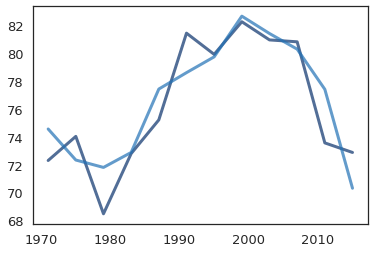

In [333]:
plot_series(result.actual)
plot_series(result.retro)

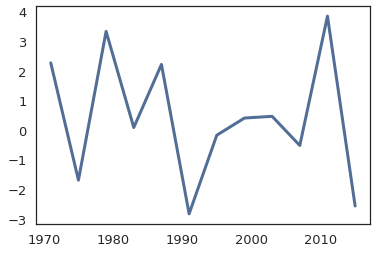

In [334]:
plot_series(result.residual)

In [337]:
def run(formula, iters=101):
    """Run the model several times and return a collection of results.
    
    iters: number of times to run
    
    returns: list of DataFrames
    """
    results = []
    for sample in read_samples(iters):
        subset = sample.dropna(subset=['gunlaw'])
        model = smf.logit(formula, data=subset).fit()
        result = make_result(sample, model)
        results.append(result)
    return results

In [338]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
results = run(formula);

Optimization terminated successfully.
         Current function value: 0.502128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507539
  

Optimization terminated successfully.
         Current function value: 0.501293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501220
  

In [373]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [374]:
def get_percentiles(series_seq, ps=None):
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    ps = np.asarray(ps)
    xs, rows = percentile_rows(series_seq, ps)
    return xs, rows

In [375]:
def plot_percentiles(series_seq, color, label, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    series_seq: sequence of Series
    color: string color
    label: string label
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    xs, rows = get_percentiles(series_seq)
    if fill:
        thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
    if plot:
        thinkplot.plot(xs, rows[1], color=color, label=label)

Writing gss_gun1.pdf
Writing gss_gun1.png


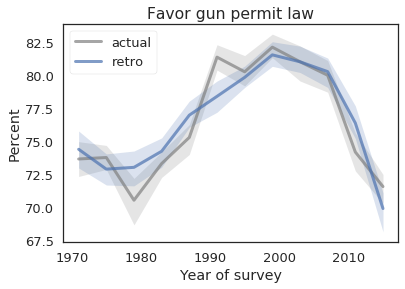

In [377]:
actual = [result.actual for result in results]
plot_percentiles(actual, 'gray', 'actual')

retro = [result.retro for result in results]
plot_percentiles(retro, 'C0', 'retro')

thinkplot.config(xlabel='Year of survey', ylabel='Percent',
                title='Favor gun permit law', loc='upper left')

thinkplot.save('gss_gun1', clf=False)

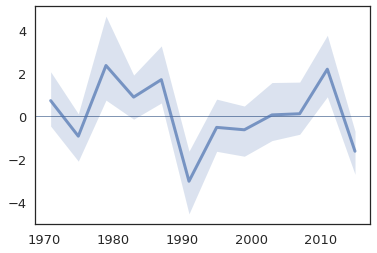

In [378]:
thinkplot.axhline(0)
residual = [result.residual for result in results]

plot_percentiles(residual, 'C0', 'residual')

In [344]:
xs, rows = get_percentiles(results, 'residual')
abs(rows[1]).mean()

1.2340288253444573

In [ ]:
stop

## Favor gunlaw

In [347]:
for sample in read_samples(1):
    pass

In [348]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

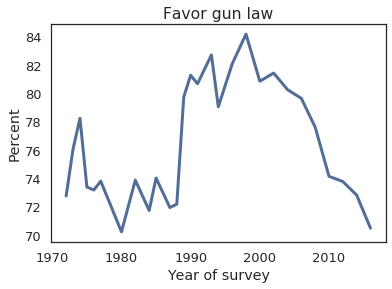

In [360]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor').dropna()
thinkplot.plot(favor)
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 title='Favor gun law')

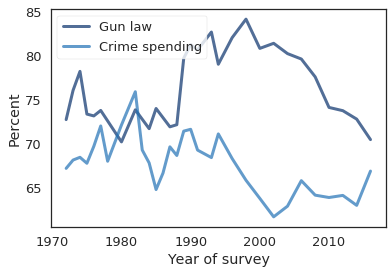

In [362]:
crime = make_series(grouped_year, 'spendcrime')

thinkplot.plot(favor, label='Gun law')
thinkplot.plot(crime, label='Crime spending')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent')

In [381]:
favor_seq = []
crime_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('year')
    favor = make_series(grouped_year, 'favor').dropna()
    crime = make_series(grouped_year, 'spendcrime')

    favor_seq.append(favor)
    crime_seq.append(crime)

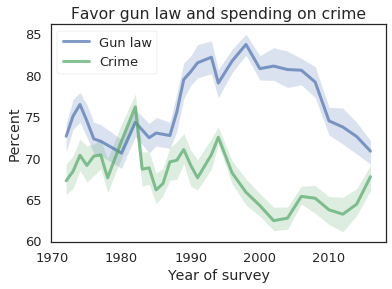

In [385]:
plot_percentiles(favor_seq, 'C0', 'Gun law')
plot_percentiles(crime_seq, 'C1', 'Crime')

thinkplot.config(title='Favor gun law and spending on crime',
                 xlabel='Year of survey', 
                 ylabel='Percent')

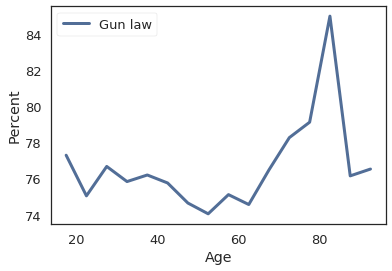

In [388]:
grouped_age = sample.groupby(['age5'])
favor = make_series(grouped_age, 'favor').dropna()
thinkplot.plot(favor, label='Gun law')
thinkplot.config(xlabel='Age', 
                 ylabel='Percent')

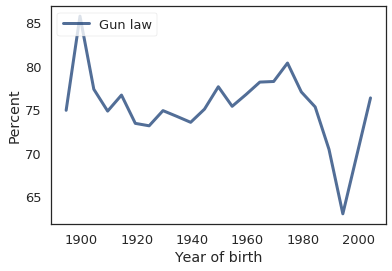

In [390]:
grouped_cohort = sample.groupby(['cohort5'])
favor = make_series(grouped_cohort, 'favor').dropna()
thinkplot.plot(favor, label='Gun law')
thinkplot.config(xlabel='Year of birth', 
                 ylabel='Percent')

In [400]:
for name, group in grouped_cohort:
    print(name, len(group))

1894.5 259
1899.5 436
1904.5 758
1909.5 1112
1914.5 1729
1919.5 2394
1924.5 2991
1929.5 3152
1934.5 3409
1939.5 4033
1944.5 4858
1949.5 6173
1954.5 6706
1959.5 6241
1964.5 4992
1969.5 3985
1974.5 3070
1979.5 2633
1984.5 1770
1989.5 1052
1994.5 538
2004.5 175


In [393]:
heri = pd.read_csv('heri_gun_control.csv');

In [394]:
heri.year

0     1989
1     1990
2     1991
3     1992
4     1993
5     1994
6     1995
7     1996
8     1997
9     1998
10    1999
11    2000
12    2001
13    2002
14    2003
15    2004
16    2005
17    2006
18    2007
19    2008
20    2010
21    2013
22    2016
Name: year, dtype: int64

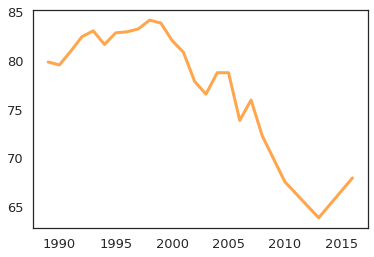

In [395]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

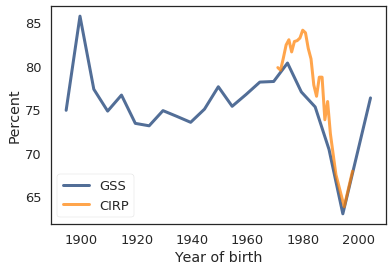

In [399]:
thinkplot.plot(favor, label='GSS')
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth',
                 ylabel='Percent',
                 loc='lower left')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year4'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year4')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)

### Test counterfactual code

In [ ]:
# may not need this any more, since sample is a copy
counterfact = sample.copy();

In [ ]:
def flip(df, varname, val, new_val, prob):
    """Changes the value of a variable for a random sample of rows.
    
    Selects each row where varname==val with probability prob, and
    replaces val with new_val.
    
    df: DataFrame
    varname: string
    val: old value
    new_val: new value
    prob: probability of flipping
    """
    assert(0 < prob < 1)
    #print('flip', val, new_val, prob)
    
    # get indices of the rows that match val
    indices = np.flatnonzero(df[varname] == val)
    #print(len(indices) * prob)
    
    # flip a coin for each selected row
    cond = np.random.random(len(indices)) < prob

    # get indices of the rows that will flip
    flippers = indices[cond]
    #print(len(flippers))
    #print((df.loc[flippers, varname] == val).mean())
    
    # assign the new val to the selected rows
    labels = df.index[flippers]
    df.loc[labels, varname] = new_val

In [ ]:
counterfact.college.value_counts()

In [ ]:
flip(counterfact, 'college', 1, 0, 0.1)

In [ ]:
counterfact.college.value_counts()

In [ ]:
def adjust_prob(df, varname, desired):
    """Flip enough people to make the mean of varname equal desired.

    varname must be a 0,1 boolean

    Can only reliably make small changes.

    df: DataFrame
    varname: string column name
    desired: value between 0 and 1
    """
    actual = df[varname].mean()
    diff = desired - actual
    #print(actual, diff)
    if diff > 0:
        prob = diff / (1-actual)
        flip(df, varname, 0, 1, prob)
    elif diff < 0:
        prob = -diff / actual
        flip(df, varname, 1, 0, prob)

In [ ]:
counterfact.college.value_counts()

In [ ]:
adjust_prob(counterfact, 'college', 0.9)

In [ ]:
counterfact.college.value_counts()

In [ ]:
counterfact.college.mean()

In [ ]:
def make_counterfactual(sample, varname, desired):
    """Modifies a groupby so the proportion of varname is constant.
    
    sample: DataFrame
    varname: string column name
    desired: value to level out at
    """
    result = {}
    counterfact = sample.copy()
    grouped = counterfact.groupby('year4')
    for name, group in grouped:        
        after = group.copy()
        adjust_prob(after, varname, desired)
        result[name] = after

    return result

In [ ]:
grouped = sample.groupby('year4')
for name, group in grouped:
    print(name, group.black.mean())

In [ ]:
prob = grouped_year4.black.mean()[1971]

In [ ]:
counter_groups = make_counterfactual(sample, 'black', prob);

In [ ]:
for name, group in grouped:
    counter_group = counter_groups[name]
    print(name, group.black.mean(), counter_group.black.mean())

In [ ]:
predict_favor(counterfact, model)

In [ ]:
actual = pd.Series([])
retro = pd.Series([])
counter = pd.Series([])

for name, group in grouped:
    counter_group = counter_groups[name]

    retro[name] = predict_favor(group, model)
    counter[name] = predict_favor(counter_group, model)
    actual[name] = group.favor.mean() * 100

#thinkplot.plot(actual.index, actual, color='gray', label='actual')
thinkplot.plot(retro.index, retro, color='gray', label='retro')
thinkplot.plot(counter.index, counter, color='C0', label='counter')

thinkplot.config()

### Run counterfactuals